# Read CWFs


### JA, AS
### January 2021

In [1]:
import glob
import numpy  as np
import tables  as tb
import pandas  as pd

from invisible_cities.cities.components import wf_from_files, get_event_info, get_run_number

from enum        import Enum

In [2]:
import matplotlib.pyplot as plt


In [3]:
#import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

pltext.style()

### Code

In [4]:
class WfType(Enum):
    rwf  = 0
    ccwf = 1
    mcrd = 2

def get_pmt_wfs(h5in, wf_type):
    if   wf_type is WfType.rwf : return h5in.root.RD.pmtrwf
    elif wf_type is WfType.ccwf: return h5in.root.RD.pmtccwf
    elif wf_type is WfType.mcrd: return h5in.root.   pmtrd
    else                       : raise  TypeError(f"Invalid WfType: {type(wf_type)}")

def get_sipm_wfs(h5in, wf_type):
    if   wf_type is WfType.rwf : return h5in.root.RD.pmtccwf
    elif wf_type is WfType.ccwf: return h5in.root.RD.sipmwf
    elif wf_type is WfType.mcrd: return h5in.root.   sipmrd
    else                       : raise  TypeError(f"Invalid WfType: {type(wf_type)}")

In [5]:
idir  = '/home/hernando/data/NEW/'
ifile = 'NEW_tlde_wfs_calibrated.h5'
h5in  = tb.open_file(idir + ifile, 'r')

In [6]:
h5in

File(filename=/home/hernando/data/NEW/NEW_tlde_wfs_calibrated.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/RD (Group) ''
/RD/pmtccwf (EArray(6069, 12, 64000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 4, 64000)
/RD/sipmwf (EArray(6069, 1792, 1600), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 163, 1600)
/Run (Group) ''
/Run/events (Table(6069,), shuffle, zlib(4)) 'event info table'
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshape := (5461,)
/Run/runInfo (Table(6069,), shuffle, zlib(4)) 'run info table'
  description := {
  "run_number": Int32Col(shape=(), dfl

In [7]:
events = h5in.root.Run.events
pmts   = h5in.root.RD.pmtccwf
sipms  = h5in.root.RD.sipmwf

In [49]:
def evt_signal(evtpmts, evtsipms):
    
    qpmt  = evtpmts .sum(axis = 0)
    qsipm = evtsipms.sum(axis = 0)
    
    return qpmt, qsipm

def evt_peaks(qpmt, qsipm):
    
    sel       = qpmt > 0.
    
    lsel      = np.full(len(sel), True)
    lsel[1:]  = sel[:-1] 
    index0    = np.argwhere(sel & ~lsel)
    rsel      = np.full(len(sel), True)
    rsel[:-1] = sel[1:] 
    index1    = np.argwhere(sel & ~rsel)
    peaks     = [(int(i0), int(i1)) for i0, i1 in zip(index0, index1)]
    
    peaks     = sorted(peaks, key = lambda peak : peak[1] - peak[0], reverse = True)
    epeaks    = [np.sum(qpmt[i0 : i1 + 1])               for i0, i1 in peaks]
    qpeaks    = [np.sum(qsipm[int(i0 * 0.025): int(i1 * 0.025) + 1]) for i0, i1 in peaks]    
    size      = [0.025 * (i1 - i0 + 1) for i0, i1 in peaks]
    
    return np.array(epeaks), np.array(qpeaks), np.array(size), peaks


In [50]:
def plot_evt(evtpmts, evtsipms):
    
    qpmt, qsipm = evt_signal(evtpmts, evtsipms)
    peaks       = evt_peaks (qpmt, qsipm)
    
    subplot = pltext.canvas(4, 2)

    subplot(1)
    plt.plot(qpmt)
    plt.yscale('log'); plt.grid();
    plt.xlabel('time bins'); plt.ylabel('PMT sum (pes)')
    
    subplot(2)
    pltext.hist(qpmt, 100); plt.yscale('log')
    
    subplot(3)
    plt.plot(qsipm); 
    plt.yscale('log'); plt.grid(); 
    plt.xlabel('time bins'); plt.ylabel('SiPM sum (pes)')
    
    subplot(4)
    pltext.hist(qsipm, 100); plt.yscale('log')
    
    return


def plot_evt_peaks(evtpmts, evtsipms):
    
    qpmt, qsipm = evt_signal(evtpmts, evtsipms)
    epks, qpks, tpks, ipks  = evt_peaks (qpmt, qsipm)
    
    subplot = pltext.canvas(4, 2)

    subplot(1)
    pltext.hist(epks, 100); plt.xlabel('peaks PMT (pes)')
    
    subplot(2)
    pltext.hist(qpks, 100); plt.xlabel('peaks SiPMs (pes)')
    
    subplot(3)
    pltext.hist(tpks, 100); plt.xlabel('peaks size (us)')
    
    #subplot(4)
    #pltext.hist(qsipm, 100); plt.yscale('log')
    
    return

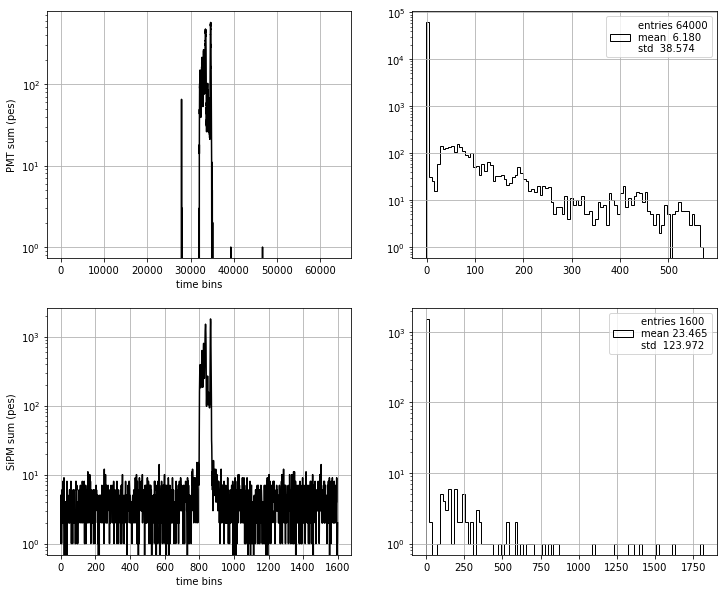

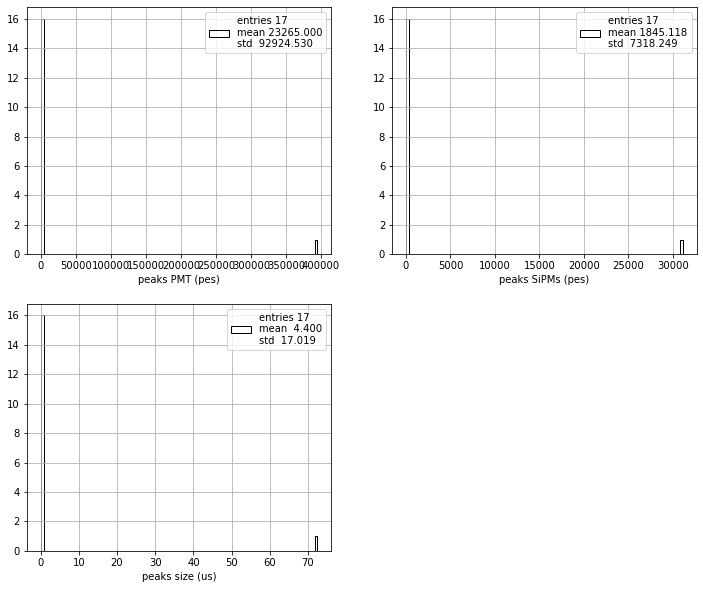

In [51]:
ievt = 10

plot_evt      (pmts[ievt], sipms[ievt])
plot_evt_peaks(pmts[ievt], sipms[ievt])

In [53]:
nevts = len(pmts)
labels = ['etot', 'qtot', 'npks', 'epk0', 'qpk0', 'tpk0']
data  = {}
for label in labels:
    data [label] = np.zeros(nevts)
for i in range(nevts):
    qpmt, qsipm            = evt_signal(pmts[i], sipms[i])
    epks, qpks, tpks, ipks = evt_peaks(qpmt, qsipm)
    data['etot'][i] = np.sum(epks)
    data['qtot'][i] = np.sum(qpks)
    data['npks'][i] = len(epks)
    data['epk0'][i] = epks[0]
    data['qpk0'][i] = qpks[0]
    data['tpk0'][i] = tpks[0]

df = pd.DataFrame(data)

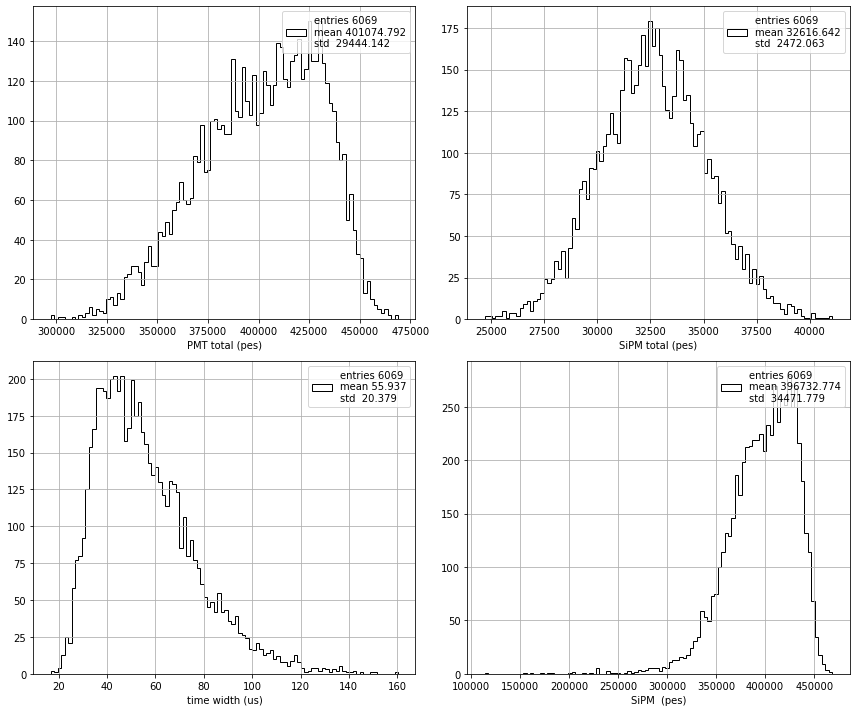

In [65]:
subplot = pltext.canvas(4, 2)

subplot(1)
pltext.hist(df.etot, 100);
plt.xlabel('PMT total (pes)')

subplot(2)
pltext.hist(df.qtot, 100);
plt.xlabel('SiPM total (pes)')

subplot(3)
pltext.hist(df.tpk0, 100);
plt.xlabel('time width (us)');

subplot(4)
pltext.hist(df.epk0, 100);
plt.xlabel('SiPM  (pes)');
plt.tight_layout()

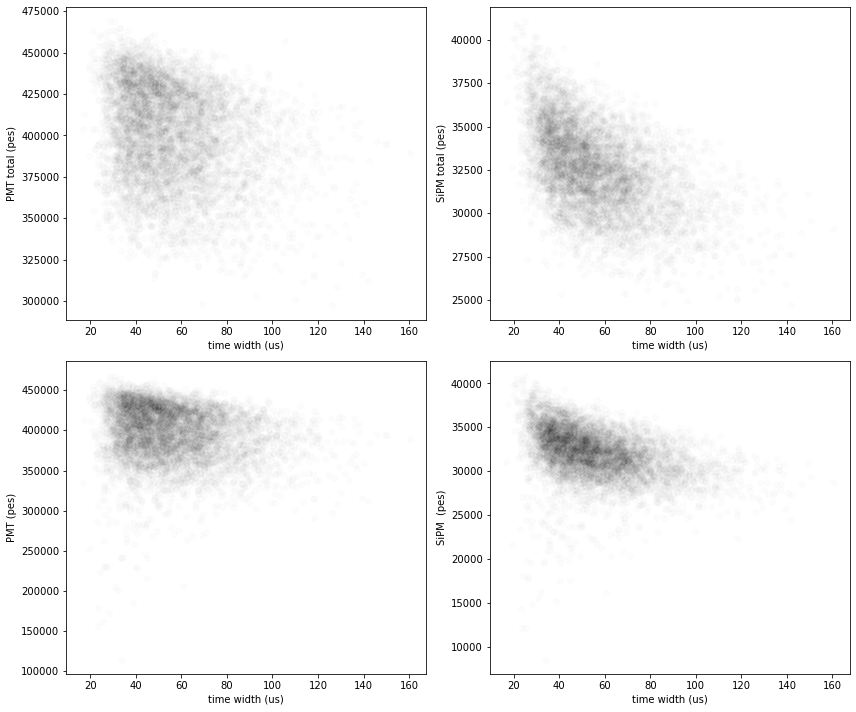

In [66]:
subplot = pltext.canvas(4, 2)

subplot(1)
plt.scatter(df.tpk0, df.etot, alpha = 0.01);
plt.xlabel('time width (us)'); plt.ylabel('PMT total (pes)')

subplot(2)
plt.scatter(df.tpk0, df.qtot, alpha = 0.01);
plt.xlabel('time width (us)'); plt.ylabel('SiPM total (pes)')

subplot(3)
plt.scatter(df.tpk0, df.epk0, alpha = 0.01);
plt.xlabel('time width (us)'); plt.ylabel('PMT (pes)')

subplot(4)
plt.scatter(df.tpk0, df.qpk0, alpha = 0.01);
plt.xlabel('time width (us)'); plt.ylabel('SiPM  (pes)');
plt.tight_layout()

**Conclusions**:

   * The delta-z effect is visible in the raw data for PMTs and SiPMs raw data with q >1. 
   